In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
# import matplotlib.pyplot as plt


TIME_STEPS = 63
EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

OFF_DAYS = False

WAREHOUSE = ["Prague_2", "Munich_1", "Frankfurt_1", "Budapest_1"]

# Temporal features
#LAG_DAYS = [1, 7, 28, 56, 84, 168, 364]  # this somehow yields better results
#ROLLING_WINDOW = [7, 28, 56, 168, 364]  # this somehow yields better results
LAG_DAYS = [63, 119, 168, 364]  # this lag bridges the whole test dataset with past data
ROLLING_WINDOW = [63, 168, 364]  # this lag bridges the whole test dataset with past data
pd.set_option('display.max_columns', None)


for dirname,_,filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

data/roh/test.csv
data/roh/test_proc_mt.csv
data/roh/train.csv
data/roh/solution_example.csv
data/roh/test_calendar.csv
data/roh/train_calendar.csv
data/arena/sample_submission.csv
data/arena/test.csv
data/arena/train.csv


In [2]:
train = pd.read_csv('data/roh/train.csv')
test = pd.read_csv('data/roh/test.csv')

train_calender = pd.read_csv('data/roh/train_calendar.csv')
test_calender = pd.read_csv('data/roh/test_calendar.csv')

In [ ]:
train

In [3]:
common_columns = set(train.columns).intersection(set(train_calender.columns))
common_columns


def merge_on_common_columns(train_df,calender_df):
    common_columns = set(train_df.columns).intersection(set(calender_df.columns))
    print(common_columns)

    return pd.merge(train_df,calender_df,on=list(common_columns))




In [4]:
train_df_merged = merge_on_common_columns(train,train_calender)
test_df_merged = merge_on_common_columns(test,test_calender)


{'warehouse', 'date', 'blackout', 'snow', 'holiday', 'winter_school_holidays', 'holiday_name', 'shops_closed', 'shutdown', 'mini_shutdown', 'school_holidays', 'frankfurt_shutdown', 'precipitation', 'mov_change'}
{'warehouse', 'date', 'holiday', 'winter_school_holidays', 'shops_closed', 'school_holidays', 'holiday_name'}


In [5]:
train_df = train_df_merged.sort_values(by=['date','warehouse'])
test_df = test_df_merged.sort_values(by=['date','warehouse'])


In [6]:
unavailable_columns = list(set(train_df.columns).difference(set(test_df.columns)))
unavailable_columns.remove('orders')

In [7]:
train_df.drop(columns=unavailable_columns,inplace=True)
train_df

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
1193,Brno_1,2020-12-05,6447.0,NaN,0,0,0,0,Brno_1_2020-12-05
6186,Budapest_1,2020-12-05,4623.0,NaN,0,0,0,0,Budapest_1_2020-12-05
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05
2386,Prague_2,2020-12-05,4154.0,NaN,0,0,0,0,Prague_2_2020-12-05
3579,Prague_3,2020-12-05,4091.0,NaN,0,0,0,0,Prague_3_2020-12-05
...,...,...,...,...,...,...,...,...,...
6185,Frankfurt_1,2024-03-15,1916.0,NaN,0,0,0,0,Frankfurt_1_2024-03-15
5556,Munich_1,2024-03-15,6512.0,NaN,0,0,0,0,Munich_1_2024-03-15
1192,Prague_1,2024-03-15,11917.0,NaN,0,0,0,0,Prague_1_2024-03-15
3578,Prague_2,2024-03-15,7140.0,NaN,0,0,0,0,Prague_2_2024-03-15


In [8]:
for i,group in train_df.groupby('warehouse'):
    unchanging_columns = []

    for col in group.columns:
        if col in ['warehouse', 'date']:
            continue

        values = group[col].nunique()

        if values == 1:
            print(f"Feature {col} has {values} unique values")
            print(f"Value: {group[col].unique()}")
            if col not in unchanging_columns:
                unchanging_columns.append(col)
        if values == 2:
            print(f"Feature {col} has {values} unique values")
            true_count = sum(group[col] == 1)
            total_count = len(group[group['warehouse'] == i])
            print(f"{true_count} items True of {total_count}")

    print(f"    Unchanging columns in {i}: {unchanging_columns}")

Feature holiday has 2 unique values
45 items True of 1193
Feature shops_closed has 2 unique values
20 items True of 1193
Feature winter_school_holidays has 2 unique values
28 items True of 1193
Feature school_holidays has 1 unique values
Value: [0]
    Unchanging columns in Brno_1: ['school_holidays']
Feature holiday has 2 unique values
9 items True of 1154
Feature shops_closed has 1 unique values
Value: [0]
Feature winter_school_holidays has 2 unique values
6 items True of 1154
Feature school_holidays has 1 unique values
Value: [0]
    Unchanging columns in Budapest_1: ['shops_closed', 'school_holidays']
Feature holiday has 2 unique values
5 items True of 629
Feature shops_closed has 1 unique values
Value: [0]
Feature winter_school_holidays has 2 unique values
17 items True of 629
Feature school_holidays has 2 unique values
24 items True of 629
    Unchanging columns in Frankfurt_1: ['shops_closed']
Feature holiday has 2 unique values
6 items True of 785
Feature shops_closed has 1 uni

In [9]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [10]:
train_df = pd.concat([train_df, test_df], axis=0)

train_df = train_df.drop(columns=['holiday_name'])

train_df = train_df.sort_values(by=['date', 'warehouse'], ignore_index=True)

train_df.head(7)


,warehouse,date,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Brno_1,2020-12-05,6447.0,0,0,0,0,Brno_1_2020-12-05
1,Budapest_1,2020-12-05,4623.0,0,0,0,0,Budapest_1_2020-12-05
2,Prague_1,2020-12-05,6895.0,0,0,0,0,Prague_1_2020-12-05
3,Prague_2,2020-12-05,4154.0,0,0,0,0,Prague_2_2020-12-05
4,Prague_3,2020-12-05,4091.0,0,0,0,0,Prague_3_2020-12-05
5,Brno_1,2020-12-06,5338.0,0,0,0,0,Brno_1_2020-12-06
6,Budapest_1,2020-12-06,4197.0,0,0,0,0,Budapest_1_2020-12-06


In [11]:
from math import pi
def process_date(df):
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract date-related features
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    #df['day_of_year'] = df['date'].dt.dayofyear
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    
    # Calculate days since the start date
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    
    # Create cyclic features
    def cyclical_encode(df, col, max_val):
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    
    cyclical_encode(df, 'month', 12)
    #cyclical_encode(df, 'day_of_week', 7)
    #cyclical_encode(df, 'day_of_year', 365)
    #cyclical_encode(df, 'day', 30)

    categorical_features = ['day_of_week', 'month', 'quarter', 'day', "year"]
    binary_features = ['is_weekend']
    return df, categorical_features, binary_features

In [12]:
def create_lag_features(df, col, lag_days):
    df = df.copy()
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df[col].rolling(window, min_periods=1).mean()
        df[std_feature] = df[col].rolling(window, min_periods=1).std()
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

In [13]:
train_df, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

In [14]:
x_scaler_features = list(set(train_df.columns) - set(categorical_features) - set(binary_features) - {'warehouse', 'orders', 'id', 'date'})
print(x_scaler_features)
print(categorical_features)

['month_sin', 'month_cos', 'days_since_start']
['day_of_week', 'month', 'quarter', 'day', 'year']


In [15]:
train_df.head(7)

,warehouse,date,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,is_weekend,days_since_start,month_sin,month_cos
0,Brno_1,2020-12-05,6447.0,0,0,0,0,Brno_1_2020-12-05,4,2020,12,5,5,1,0,-2.449294e-16,1.0
1,Budapest_1,2020-12-05,4623.0,0,0,0,0,Budapest_1_2020-12-05,4,2020,12,5,5,1,0,-2.449294e-16,1.0
2,Prague_1,2020-12-05,6895.0,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,1,0,-2.449294e-16,1.0
3,Prague_2,2020-12-05,4154.0,0,0,0,0,Prague_2_2020-12-05,4,2020,12,5,5,1,0,-2.449294e-16,1.0
4,Prague_3,2020-12-05,4091.0,0,0,0,0,Prague_3_2020-12-05,4,2020,12,5,5,1,0,-2.449294e-16,1.0
5,Brno_1,2020-12-06,5338.0,0,0,0,0,Brno_1_2020-12-06,4,2020,12,6,6,1,1,-2.449294e-16,1.0
6,Budapest_1,2020-12-06,4197.0,0,0,0,0,Budapest_1_2020-12-06,4,2020,12,6,6,1,1,-2.449294e-16,1.0


In [16]:
# train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

# plt.figure(figsize=(12, 8))
# sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Matrix')
# plt.show()

# # Print the correlation with 'orders'
# print(train_df_corr['orders'].sort_values(ascending=False))
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import joblib
import os
# import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import interpolate

In [17]:
def preprocess_data(df, cat_features, x_scaler_features, binary_features, redundant_features=[], inference=False, fill_method='ffill'):
    warehouse = df['warehouse'].iloc[0]
    redundant_df = df[redundant_features]
    df = df.drop(columns=redundant_features)
    
    if not inference:
        # Create lag and rolling features
        df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
        df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)
        
        x_scaler_features = x_scaler_features + lag_features + window_features
        
        # Handle NaN values in lag and rolling features
        if fill_method == 'ffill':
            df[lag_features + window_features] = df[lag_features + window_features].ffill().bfill()
            orders = df["orders"]
            df = df.ffill().bfill()
            df["orders"] = orders
            
        elif fill_method == 'zero':
            df[lag_features + window_features] = df[lag_features + window_features].fillna(0)
            orders = df["orders"]
            df = df.fillna(0)
            df["orders"] = orders

    # One-hot encoding for categorical features
    if not inference:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[cat_features])
        joblib.dump(encoder, f'onehot_scaler_{warehouse}.joblib')
    else:
        encoder = joblib.load(f'onehot_scaler_{warehouse}.joblib')
        encoded_features = encoder.transform(df[cat_features])

    encoded_feature_names = encoder.get_feature_names_out(cat_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

    # Prepare features for scaling
    X = df.drop(columns=['orders'])
    y = df['orders']

    # Initialize and fit/transform scalers
    if not inference:
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X_scaled = x_scaler.fit_transform(X[x_scaler_features])
        y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        joblib.dump(x_scaler, f'x_scaler_{warehouse}.joblib')
        joblib.dump(y_scaler, f'y_scaler_{warehouse}.joblib')
    else:
        x_scaler = joblib.load(f'x_scaler_{warehouse}.joblib')
        X_scaled = x_scaler.transform(X[x_scaler_features])
        y_scaler = joblib.load(f'y_scaler_{warehouse}.joblib')
        y_scaled = y_scaler.transform(y.values.reshape(-1, 1))

    # Create DataFrame with scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features, index=df.index)

    # Combine all features
    final_df = pd.concat([
        X_scaled_df,  # Scaled numerical features
        encoded_df,   # One-hot encoded categorical features
        df[binary_features],  # Binary features (unchanged)
        redundant_df  # Add redundant features back for the test data export
    ], axis=1)
    print(final_df.shape, y_scaled.shape)
    return final_df, y_scaled

In [18]:
features = [f'orders_lag_{lag}' for lag in LAG_DAYS]
features2 = [f'orders_rolling_mean_{window}' for window in ROLLING_WINDOW]

# Get unique warehouses
warehouses = train_df['warehouse'].unique()

# Create separate dataframes for each warehouse
warehouse_dfs = {wh: train_df[train_df['warehouse'] == wh].copy() for wh in warehouses}

# Preprocess each warehouse dataframe
processed_train_data_dict = {}
processed_test_data = []

for warehouse, df in warehouse_dfs.items():
    print(f"Processing warehouse: {warehouse}")
    
    # Sort dataframe by date ascendentaly
    df = df.sort_values(by=['date'])

    # Get indices of NaN values in 'orders' column
    nan_indices = df[df['orders'].isna()].index

    # Plot outlier comparison if needed
    # df = plot_outlier_comparison(df, window=70, z_threshold=2.5, weight=0.5)

    # Preprocess data
    X_processed, y_processed = preprocess_data(df, 
                                               categorical_features, 
                                               x_scaler_features, 
                                               binary_features, 
                                               redundant_features=['warehouse', 'id', 'date'], 
                                               inference=False, 
                                               fill_method='none')
    

    
    # Get test data using NaN indices
    test_data = X_processed.loc[nan_indices]
    
    # Convert index to integer positions for np.delete
    nan_positions = X_processed.index.get_indexer(nan_indices)
    
    # Drop NaN indices from processed data
    X_processed = X_processed.drop(nan_indices)
    y_processed = np.delete(y_processed, nan_positions)
    
    processed_test_data.append(test_data)
    processed_train_data_dict[warehouse] = (X_processed, y_processed)
    
    print(f"Processed:\ntrain data shape: {X_processed.shape}, {y_processed.shape}")
    print("test data shape:", test_data.shape)
    print(f"y nans: {sum(np.isnan(y_processed))}")
    print("\n")
    
# Combine all test data rows into a single DataFrame
processed_test_df = pd.concat(processed_test_data)

Processing warehouse: Brno_1
(1254, 80) (1254, 1)
Processed:
train data shape: (1193, 80), (1193,)
test data shape: (61, 80)
y nans: 0


Processing warehouse: Budapest_1
(1211, 80) (1211, 1)
Processed:
train data shape: (1154, 80), (1154,)
test data shape: (57, 80)
y nans: 0


Processing warehouse: Prague_1
(1254, 80) (1254, 1)
Processed:
train data shape: (1193, 80), (1193,)
test data shape: (61, 80)
y nans: 0


Processing warehouse: Prague_2
(1254, 80) (1254, 1)
Processed:
train data shape: (1193, 80), (1193,)
test data shape: (61, 80)
y nans: 0


Processing warehouse: Prague_3
(1254, 80) (1254, 1)
Processed:
train data shape: (1193, 80), (1193,)
test data shape: (61, 80)
y nans: 0


Processing warehouse: Munich_1
(833, 79) (833, 1)
Processed:
train data shape: (785, 79), (785,)
test data shape: (48, 79)
y nans: 0


Processing warehouse: Frankfurt_1
(677, 77) (677, 1)
Processed:
train data shape: (629, 77), (629,)
test data shape: (48, 77)
y nans: 0




In [19]:
# Save the test dataset for future use
processed_test_df.to_csv('data/roh/test_proc_mt.csv')

In [20]:
for warehouse, (X_processed, y_processed) in processed_train_data_dict.items():
    print(f"Warehouse: {warehouse}")
    print("Start Date:", X_processed["date"].min())
    print("End Date:", X_processed["date"].max())
    print()

Warehouse: Brno_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Budapest_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-14 00:00:00

Warehouse: Prague_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Prague_2
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Prague_3
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Munich_1
Start Date: 2021-07-21 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Frankfurt_1
Start Date: 2022-02-18 00:00:00
End Date: 2024-03-15 00:00:00



In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


2024-07-23 20:29:57.584173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 20:30:01.229603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [53]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled,
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

In [54]:
FILL = True

#print nan values for every warehouse in train dataset dict:
for warehouse in processed_train_data_dict.keys():
    print(f"Nan X values for {warehouse}: {processed_train_data_dict[warehouse][0].isna().sum().sum()}")
    print(f"nan y values for {warehouse}: {sum(np.isnan(processed_train_data_dict[warehouse][1]))}")
    
    if FILL:
        feat, targ = processed_train_data_dict[warehouse]

        feat = feat.fillna(0)
        targ = np.nan_to_num(targ, nan=0.0)
        processed_train_data_dict[warehouse] = (feat, targ)

if FILL:
    print("\n After FILL:")
    for warehouse in processed_train_data_dict.keys():
        print(f"Nan X values for {warehouse}: {processed_train_data_dict[warehouse][0].isna().sum().sum()}")
        print(f"nan y values for {warehouse}: {sum(np.isnan(processed_train_data_dict[warehouse][1]))}")

Nan X values for Brno_1: 0
nan y values for Brno_1: 0
Nan X values for Budapest_1: 0
nan y values for Budapest_1: 0
Nan X values for Prague_1: 0
nan y values for Prague_1: 0
Nan X values for Prague_2: 0
nan y values for Prague_2: 0
Nan X values for Prague_3: 0
nan y values for Prague_3: 0
Nan X values for Munich_1: 0
nan y values for Munich_1: 0
Nan X values for Frankfurt_1: 0
nan y values for Frankfurt_1: 0

 After FILL:
Nan X values for Brno_1: 0
nan y values for Brno_1: 0
Nan X values for Budapest_1: 0
nan y values for Budapest_1: 0
Nan X values for Prague_1: 0
nan y values for Prague_1: 0
Nan X values for Prague_2: 0
nan y values for Prague_2: 0
Nan X values for Prague_3: 0
nan y values for Prague_3: 0
Nan X values for Munich_1: 0
nan y values for Munich_1: 0
Nan X values for Frankfurt_1: 0
nan y values for Frankfurt_1: 0


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesModel(nn.Module):
    def __init__(self, input_shape, lr=1e-3):
        super(TimeSeriesModel, self).__init__()
        
        self.lstm = nn.LSTM(input_shape[2], 32, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(32 * 2, 32)  # 32 * 2 because of bidirectional LSTM
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
    
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32).to(x.device)  # 2 for bidirectional
        c0 = torch.zeros(2, x.size(0), 32).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(self.relu(self.fc1(out[:, -1, :])))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.fc3(out)
        return out

def create_model(input_shape, lr=1e-3):
    model = TimeSeriesModel(input_shape, lr)
    return model


In [49]:
# Sample input
batch_size = 32
seq_len = 63  # Length of the time series sequence
input_size = 77  # Number of input features
d_model = 64 
nhead = 4
num_encoder_layers = 3  # Number of transformer encoder layers
dim_feedforward = 256  # Dimension of the feedforward network
dropout = 0.1  # Dropout rate
max_len = 5000  # Maximum length of the time series
# Create random input data
x = torch.rand(batch_size, seq_len, input_size)

# Create model and forward pass
model = create_model(x.shape, lr=1e-3)#TimeSeriesTransformer(input_size, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, max_len)
output = model(x)
print(output.shape) 

torch.Size([32, 1])


In [57]:
import matplotlib.pyplot as plt
def plot_loss(train_losses, val_losses, warehouse):
    plt.figure(figsize=(12, 8))
    
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
    
    min_val_loss = min(val_losses)
    min_val_loss_epoch = val_losses.index(min_val_loss)
    plt.axvline(min_val_loss_epoch, linestyle='--', color='gray', linewidth=1)
    plt.text(min_val_loss_epoch, min_val_loss, f'Min Val Loss: {min_val_loss:.4f}', 
             verticalalignment='bottom', horizontalalignment='right', color='gray', fontsize=10)
    
    plt.title(f'Training and Validation Loss for Warehouse: {warehouse}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    plt.savefig(f'training_validation_loss_{warehouse}.png', dpi=300)
    plt.show()

In [58]:
def train_transformer(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if (epoch+1)%100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

Training model for warehouse: Brno_1
final shape: ((1130, 63, 77), (1130,))
(1017, 63, 77)
Epoch 100/200, Train Loss: 0.1613, Val Loss: 0.3248
Epoch 200/200, Train Loss: 0.1127, Val Loss: 0.3032


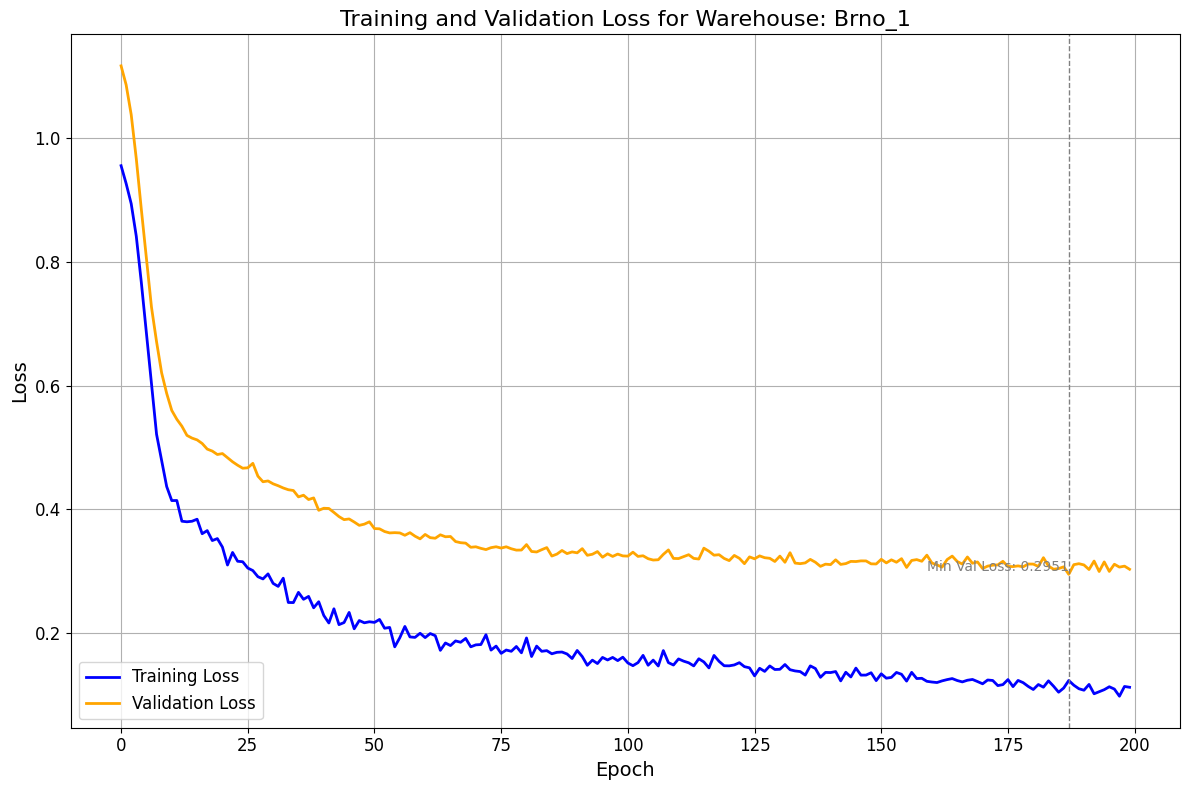

Training model for warehouse: Budapest_1
final shape: ((1091, 63, 77), (1091,))
(981, 63, 77)
Epoch 100/200, Train Loss: 0.1371, Val Loss: 0.1065
Epoch 200/200, Train Loss: 0.0843, Val Loss: 0.1081


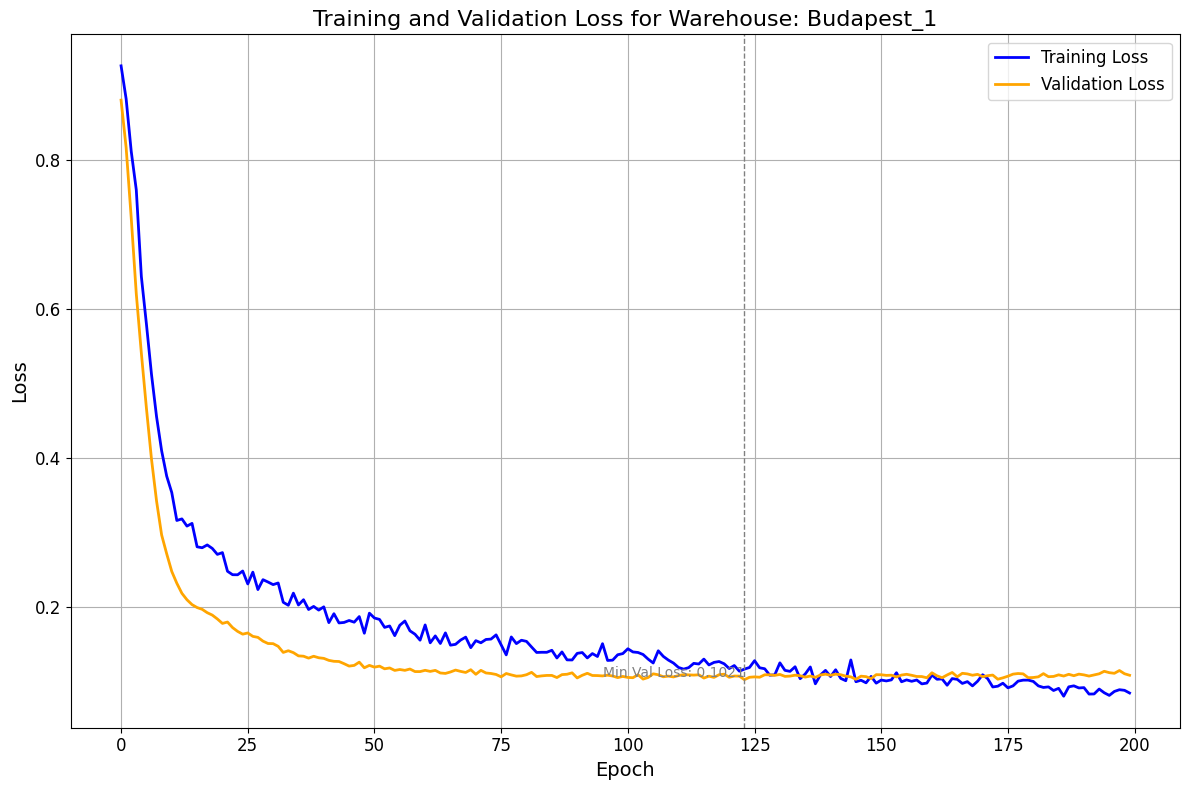

Training model for warehouse: Prague_1
final shape: ((1130, 63, 77), (1130,))
(1017, 63, 77)
Epoch 100/200, Train Loss: 0.2035, Val Loss: 0.1161
Epoch 200/200, Train Loss: 0.1054, Val Loss: 0.1318


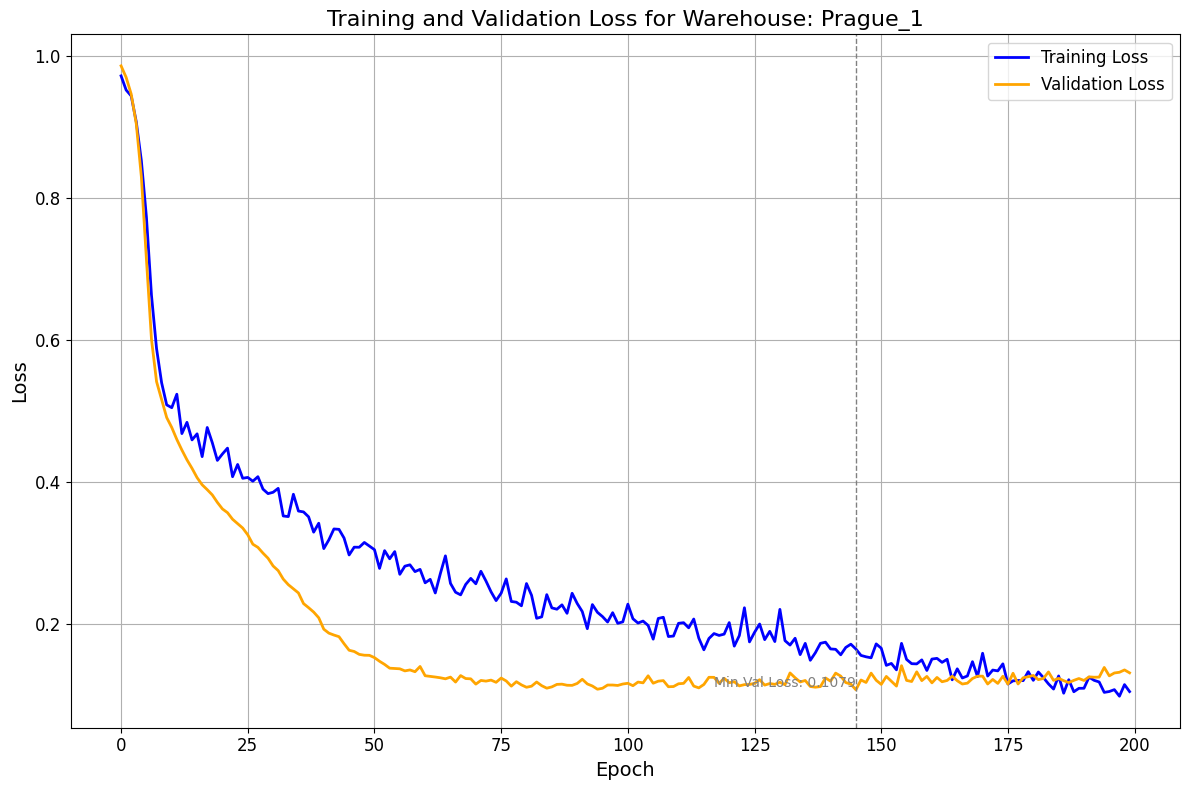

Training model for warehouse: Prague_2
final shape: ((1130, 63, 77), (1130,))
(1017, 63, 77)
Epoch 100/200, Train Loss: 0.1629, Val Loss: 0.1583
Epoch 200/200, Train Loss: 0.0935, Val Loss: 0.1631


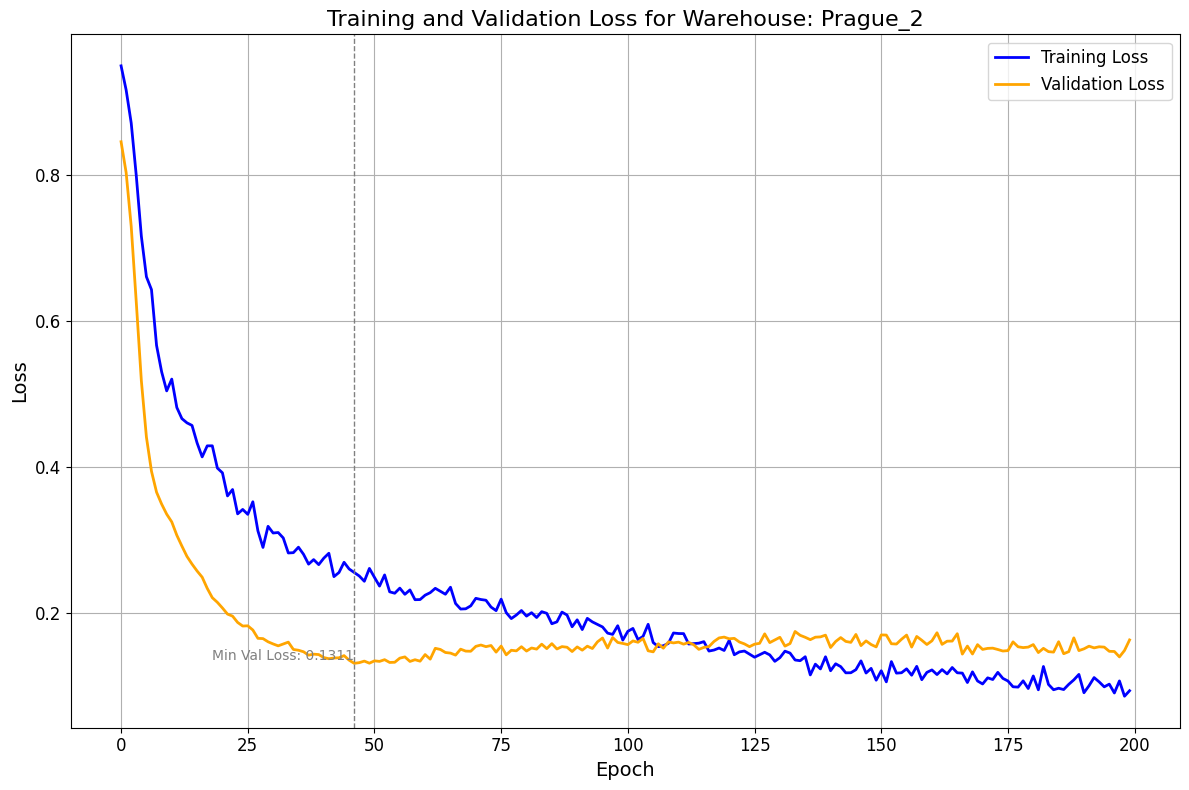

Training model for warehouse: Prague_3
final shape: ((1130, 63, 77), (1130,))
(1017, 63, 77)
Epoch 100/200, Train Loss: 0.1899, Val Loss: 0.1841
Epoch 200/200, Train Loss: 0.1166, Val Loss: 0.1552


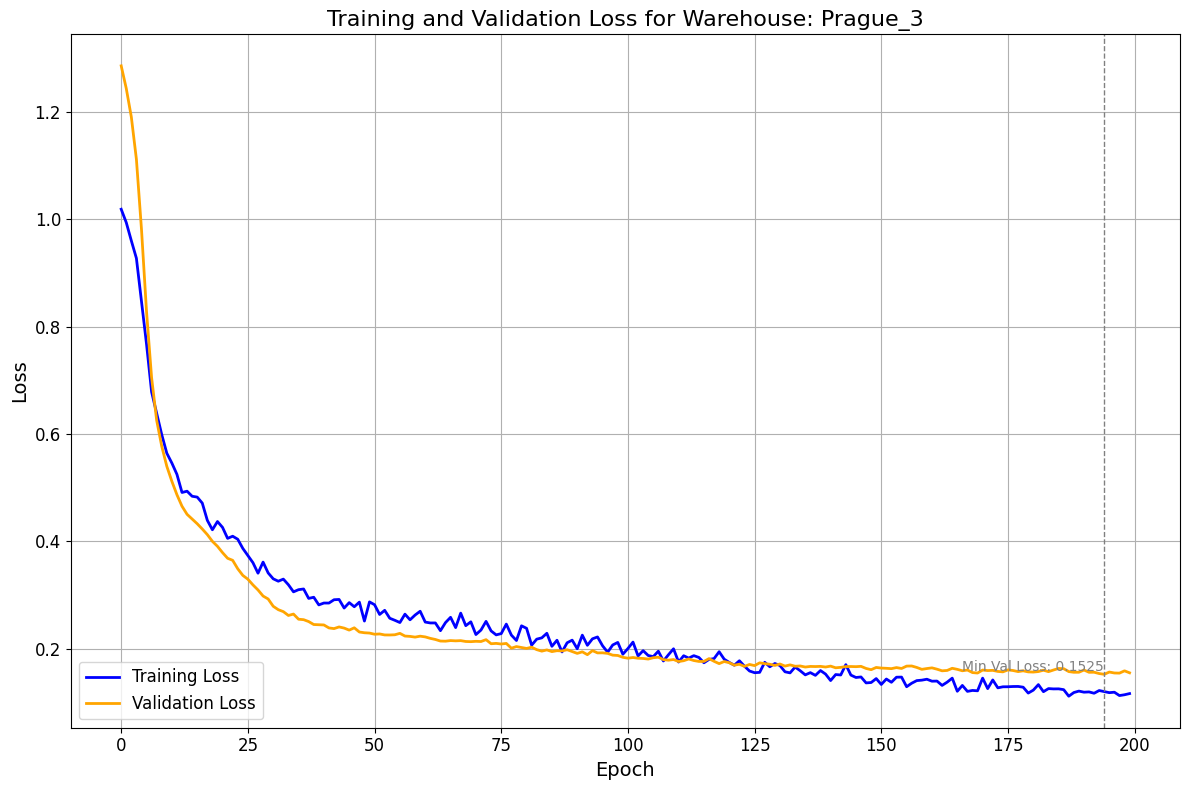

Training model for warehouse: Munich_1
final shape: ((722, 63, 76), (722,))
(649, 63, 76)
Epoch 100/200, Train Loss: 0.1082, Val Loss: 0.1336
Epoch 200/200, Train Loss: 0.0893, Val Loss: 0.1350


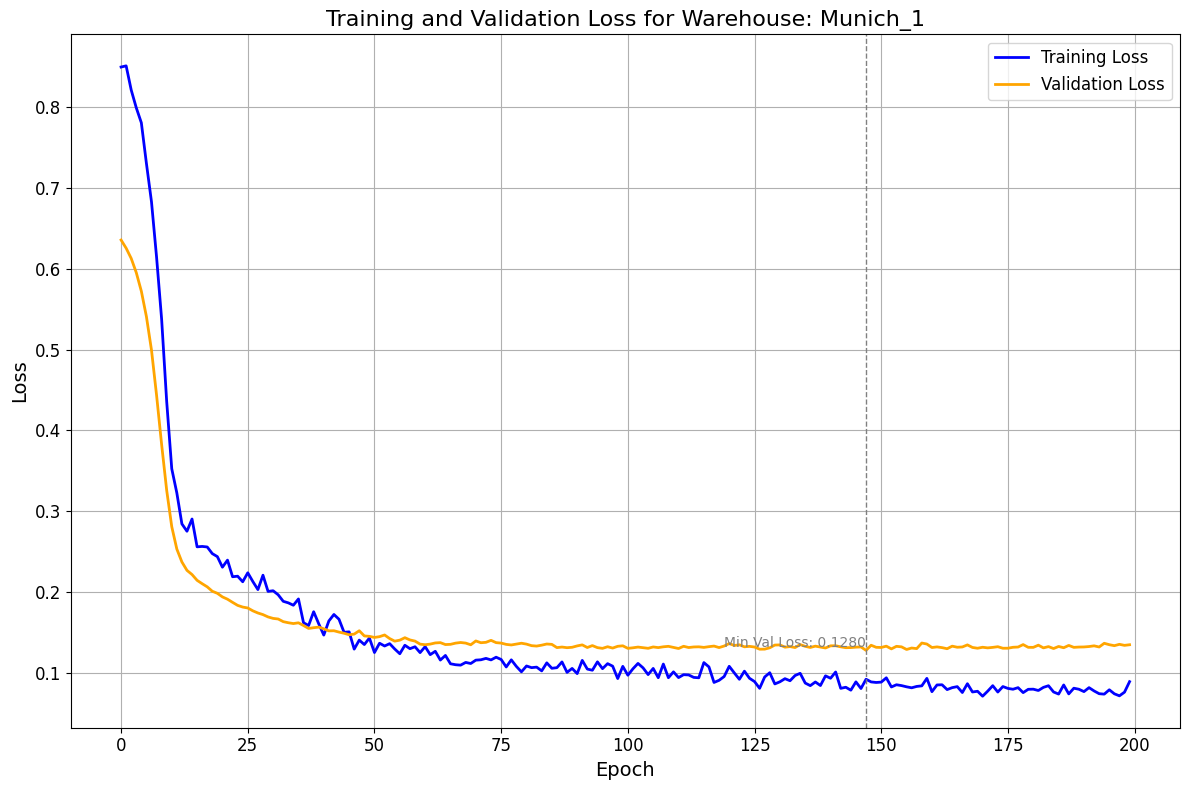

Training model for warehouse: Frankfurt_1
final shape: ((566, 63, 74), (566,))
(509, 63, 74)
Epoch 100/200, Train Loss: 0.1142, Val Loss: 0.0733
Epoch 200/200, Train Loss: 0.0774, Val Loss: 0.0747


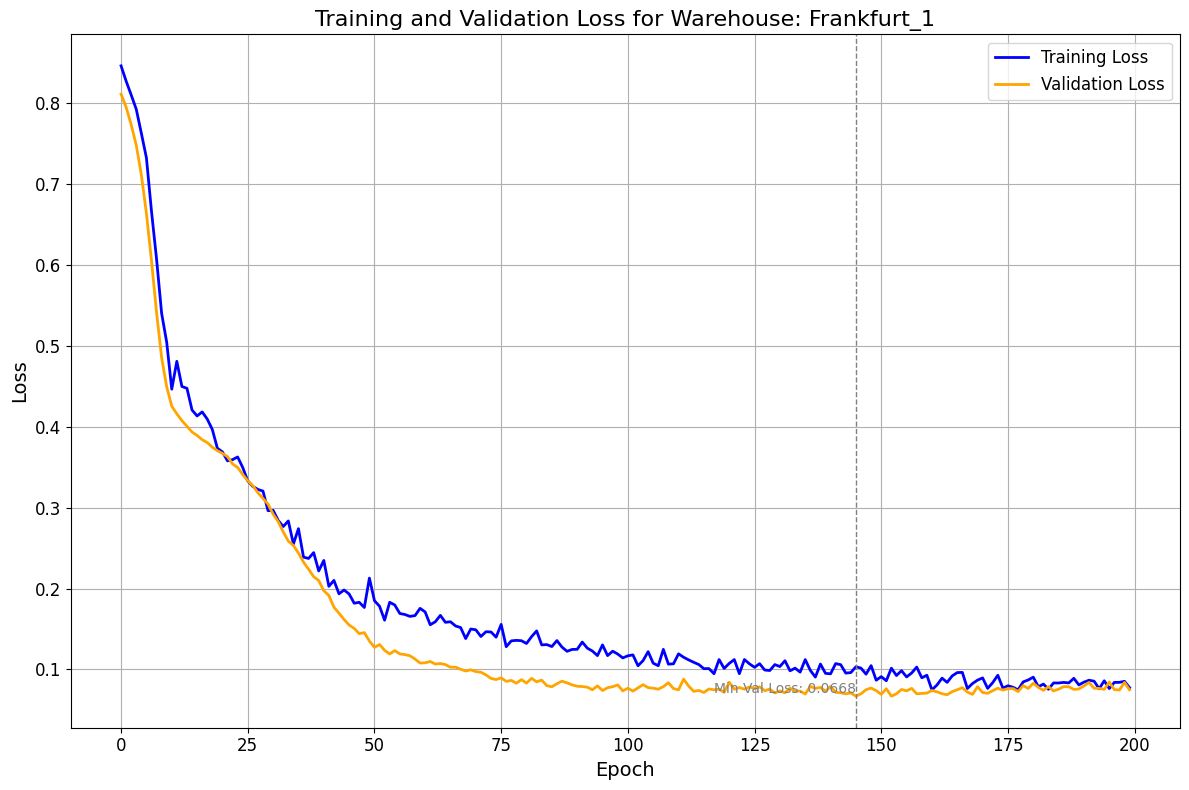

In [59]:
# Training loop:

val_data = {}
training_features = {}

for warehouse, (X_train_scaled, y_train_scaled) in processed_train_data_dict.items():
    print(f"Training model for warehouse: {warehouse}")

    X_train_scaled = X_train_scaled.drop(columns=['id', 'warehouse', 'date'])
    
    training_features[warehouse] = X_train_scaled.columns.tolist()

    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)
    
    # train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.1, shuffle=True)
    
    # Convert to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Create the model
    input_size = X_train.shape[2]
    print(X_train.shape)
    model = create_model(X_train.shape, lr=1e-3)#TimeSeriesTransformer(input_size=input_size, d_model=64, nhead=4, num_encoder_layers=3, dim_feedforward=256, dropout=0.1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    train_losses, val_losses = train_transformer(model, train_loader, val_loader, criterion, optimizer, EPOCHS)
    
    plot_loss(train_losses, val_losses, warehouse)
    
    # Save the model
    torch.save(model.state_dict(), f'model_{warehouse}.pt')
    
    # Save the validation data for future evaluation
    val_data[warehouse] = (X_val, y_val)

In [28]:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features,
    'scaler_features': x_scaler_features,
    'training_features': training_features,
}

joblib.dump(scaler_config, 'scaler_config_mt.joblib')

['scaler_config_mt.joblib']

In [85]:
def create_sequences(data, max_time_steps):

    sequences = []
    for i in range(len(data)):
        seq = data.iloc[max(0, i-max_time_steps+1):i+1].values
        if len(seq) < max_time_steps:
            padding = np.tile(seq[0], (max_time_steps - len(seq), 1))
            seq = np.vstack((padding, seq))
        sequences.append(seq)
    return np.array(sequences)

In [106]:
def predict_multiple(data, time_steps, warehouses_trained, training_features):
    predictions = []
    submission_data = []

    for warehouse in data['warehouse'].unique():
        if warehouse not in warehouses_trained:
            print(f"No model found for warehouse: {warehouse}")
            warehouse_predictions = [np.nan] * len(data[data['warehouse'] == warehouse])
            predictions.extend(warehouse_predictions)
            continue
        model_data = warehouses_trained[warehouse]
        model = model_data['model']
        y_scaler = model_data['y_scaler']
        wh_data = data[data['warehouse'] == warehouse].copy()
        wh_data = wh_data.reindex(columns=training_features[warehouse])
    
        sequences = create_sequences(wh_data, time_steps)


        # Predict on all sequences
        model.eval()
        print(model)
        preds = model(torch.tensor(sequences, dtype=torch.float32))
        preds_rescaled = y_scaler.inverse_transform(preds.detach().numpy())

        # Align predictions with original data
        wh_predictions = np.full(len(wh_data), np.nan)

        # Calculate the number of predictions
        num_predictions = len(preds_rescaled)

        # Assign predictions, accounting for the offset due to sequence creation
        wh_predictions[-num_predictions:] = preds_rescaled.flatten()
        predictions.extend(wh_predictions)

        # Prepare submission data
        wh_submission_data = data.loc[data['warehouse'] == warehouse].copy()

        wh_submission_data['predicted_orders'] = wh_predictions

        submission_data.append(wh_submission_data)

    submission_df = pd.concat(submission_data)

    return np.array(predictions), submission_df

In [107]:
def load_models_and_scalers(warehouses):
    warehouse_models_and_scalers = {}

    for wh in warehouses:
        try:
            # model  = torch.load(f'model_{wh}.pt')#tf.keras.models.load_model(f'model_{wh}.keras')
            # print(wh)
            if wh == 'Munich_1':
                model = create_model(input_shape=[2,63,76])
            elif wh == 'Frankfurt_1':
                model = create_model(input_shape=[2,63,74])
            else:
                print(wh)
                model = create_model(input_shape=x.shape)
            # print(f'model_{wh}.pt')
            model.load_state_dict(torch.load(f'model_{wh}.pt'))
            x_scaler = joblib.load(f'x_scaler_{wh}.joblib')
            
            y_scaler = joblib.load(f'y_scaler_{wh}.joblib')
            encoder = joblib.load(f'onehot_scaler_{wh}.joblib')
            
            warehouse_models_and_scalers[wh] = {
                'model': model,
                'x_scaler': x_scaler,
                'y_scaler': y_scaler,
                'encoder': encoder
            }
        except Exception as e:
            print(f"Error loading model or scaler for warehouse {wh}: {str(e)}")

    return warehouse_models_and_scalers

In [108]:
scaler_config = joblib.load('scaler_config_mt.joblib') # load the scaler config

x_scaler_features = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
categorical_features = scaler_config['cat_features']    # categorical features
binary_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
training_features = scaler_config['training_features']    # training features dictionary
    
print(f"cat_features: {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"scaler_columns: {len(x_scaler_features)}")

cat_features: ['day_of_week', 'month', 'quarter', 'day', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
scaler_columns: 3


In [109]:
dataframe = pd.read_csv("data/roh/test_proc_mt.csv")
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by=['date', 'warehouse'])
print(f"Rows: {len(dataframe)}")

Rows: 397


In [110]:
warehouse_models = load_models_and_scalers(warehouses)
predictions, submission_df = predict_multiple(dataframe, TIME_STEPS, warehouse_models, training_features)
len(submission_df.predicted_orders)

Brno_1
Budapest_1
Prague_1
Prague_2
Prague_3
TimeSeriesModel(
  (lstm): LSTM(77, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (criterion): MSELoss()
)
TimeSeriesModel(
  (lstm): LSTM(77, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (criterion): MSELoss()
)
TimeSeriesModel(
  (lstm): LSTM(74, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout

397

In [111]:
submission_export = submission_df[["id", "predicted_orders"]]

In [113]:

submission_export.to_csv('submission.csv', index=False)

# A1

In [255]:
missing_columns = train.columns[train.isnull().any()]

for column in missing_columns:
    non_missing_values = train[column].dropna().values
    train[column] = train[column].apply(lambda x: np.random.choice(non_missing_values) if pd.isnull(x) else x)

missing_columns = test.columns[test.isnull().any()]

for column in missing_columns:
    non_missing_values = test[column].dropna().values
    test[column] = test[column].apply(lambda x: np.random.choice(non_missing_values) if pd.isnull(x) else x)


train.drop(columns=['holiday_name_x', 'holiday_name_y'], inplace=True)
test.drop(columns=['holiday_name_x', 'holiday_name_y'], inplace=True)

In [256]:
train.columns,test.columns

(Index(['warehouse', 'date', 'orders', 'holiday_x', 'shutdown_x',
        'mini_shutdown_x', 'shops_closed_x', 'winter_school_holidays_x',
        'school_holidays_x', 'blackout_x', 'mov_change_x',
        'frankfurt_shutdown_x', 'precipitation_x', 'snow_x', 'user_activity_1',
        'user_activity_2', 'id', 'holiday_y', 'shutdown_y', 'mini_shutdown_y',
        'warehouse_limited', 'shops_closed_y', 'winter_school_holidays_y',
        'school_holidays_y', 'blackout_y', 'mov_change_y',
        'frankfurt_shutdown_y', 'precipitation_y', 'snow_y'],
       dtype='object'),
 Index(['warehouse', 'date', 'holiday_x', 'shops_closed_x',
        'winter_school_holidays_x', 'school_holidays_x', 'id', 'holiday_y',
        'shops_closed_y', 'winter_school_holidays_y', 'school_holidays_y'],
       dtype='object'))

In [257]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek
train['is_weekend'] = (train['dayofweek'] >= 5).astype(int)
# train['order_lag_1'] = train.groupby('warehouse')['orders'].shift(1)
# train['orders_rolling_mean_7'] = train.groupby('warehouse')['orders'].shift(1).rolling(7).mean()
train.fillna(0,inplace=True)
train = pd.get_dummies(train, columns=['warehouse'], drop_first=True)
train.drop(columns=['date'], inplace=True)

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['is_weekend'] = (test['dayofweek'] >= 5).astype(int)
# test['order_lag_1'] = test.groupby('warehouse')['orders'].shift(1)
# test['orders_rolling_mean_7'] = test.groupby('warehouse')['orders'].shift(1).rolling(7).mean()
test.fillna(0,inplace=True)
test = pd.get_dummies(test, columns=['warehouse'], drop_first=True)
test.drop(columns=['date'], inplace=True)

In [258]:
train['holiday'] = train['holiday_x'] + train['holiday_y']
train['winter_school_holidays'] = train['winter_school_holidays_x'] + train['winter_school_holidays_y']
train['school_holidays'] = train['school_holidays_x']+train['school_holidays_y']
train['shops_closed'] = train['shops_closed_x'] + train['shops_closed_y']

train  = train.drop(columns = ['holiday_x' , 'holiday_y' ,
                               'winter_school_holidays_x' , 'winter_school_holidays_y',
                               'school_holidays_x' , 'school_holidays_y',
                               'shops_closed_x' , 'shops_closed_y'
                              ])

In [259]:
test['holiday'] = test['holiday_x'] + test['holiday_y']
test['winter_school_holidays'] = test['winter_school_holidays_x'] + test['winter_school_holidays_y']
test['school_holidays'] = test['school_holidays_x']+test['school_holidays_y']
test['shops_closed'] = test['shops_closed_x'] + test['shops_closed_y']


test  = test.drop(columns = ['holiday_x' , 'holiday_y' ,
                               'winter_school_holidays_x' , 'winter_school_holidays_y',
                               'school_holidays_x' , 'school_holidays_y',
                               'shops_closed_x' , 'shops_closed_y'
                              ])

In [260]:
X = train.drop(columns=['orders'])
y = train['orders'].values

X, test = X.align(test, join='inner', axis=1)
X.drop(columns = ['id'] , inplace = True )


In [261]:
def create_sequences(data, window_size):
    sequences = []
    padding = np.zeros((window_size, data.shape[1]))
    data_padded = np.vstack((padding,data))
    for start in range(len(data)):
        if window_size-start >0:
            padding = np.zeros((window_size-start-1, data.shape[1]))
            # print(start,padding.shape,data[:start+1].shape)
            # print(np.vstack((padding,data[:start+1])).shape)
            sequences.append(np.vstack((padding,data[:start+1])))
        else:
            psudo_start = start - window_size
            # print('data:',data[psudo_start:start].shape)
            sequences.append(data[psudo_start:start])
            
    return np.array(sequences)
# train_sq_example = create_sequences(scaler.fit_transform(X[:20]), 5)

In [59]:
# train_sq_example = create_sequences(scaler_X.fit_transform(X[:20]), 5)
# # train_sq_example

In [288]:
scaler_X = MinMaxScaler()
scaler_Y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X)
y_train_scaled = y.reshape(-1,1)
X_train_sequences = create_sequences(X_train_scaled,window_size=4)
y_train_sequences = create_sequences(y.reshape(-1,1),window_size=4)

In [279]:
np.array(X,dtype='float64')

array([[2020.,   12.,    5., ...,    0.,    0.,    0.],
       [2020.,   12.,    6., ...,    0.,    0.,    0.],
       [2020.,   12.,    7., ...,    0.,    0.,    0.],
       ...,
       [2024.,    3.,   12., ...,    0.,    0.,    0.],
       [2024.,    3.,   13., ...,    0.,    0.,    0.],
       [2024.,    3.,   14., ...,    0.,    0.,    0.]])

In [289]:
X_train, X_val, y_train, y_val = train_test_split(X_train_sequences, y_train_scaled, test_size=0.2, random_state=42)

In [290]:
print('X_train shape :',X_train.shape)
print('X_val shape :',X_val.shape)
print('y_train shape : ',y_train.shape)
print('y_val shape : ',y_val.shape)

X_train shape : (5872, 4, 15)
X_val shape : (1468, 4, 15)
y_train shape :  (5872, 1)
y_val shape :  (1468, 1)


In [200]:
# # creatting sequence for LSTM
# def create_sequences(X, y=None, time_steps=7, train=True):
#     if train:
#         Xs, ys = [], []
#         for i in range(len(X) - time_steps):
#             Xs.append(X[i:(i + time_steps)])
#             ys.append(y[i + time_steps])
#         return np.array(Xs), np.array(ys)
#     else:
#         Xs = []
#         for i in range(len(X) - time_steps + 1):
#             Xs.append(X[i:i + time_steps])
#         return np.array(Xs)
        
# train_sq_example = create_sequences(scaler_X.fit_transform(X[:20]),train=False)
# # # train_sq_example

In [201]:
# train_sq_example.shape

## nn

In [291]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [292]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 4, d_model))  # Assuming window size 10
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout),
            num_layers=num_encoder_layers)
        self.fc1 = nn.Linear(d_model,d_model)
        
        self.fc_out = nn.Linear(d_model, 1)

    
    def forward(self, x):
        x = self.embedding(x)# + self.positional_encoding
        x = self.transformer_encoder(x)
        x = torch.relu(self.fc1(x.mean(dim=1)))#x.mean(dim=1)  # Global average pooling
        return self.fc_out(x)

input_size = 15  # Number of features
model = TimeSeriesTransformer(input_size, d_model=128, nhead=8, num_encoder_layers=3, dim_feedforward=512, dropout=0.1)


# class MAPELoss(nn.Module):
#     def __init__(self):
#         super(MAPELoss, self).__init__()

#     def forward(self, y_pred, y_true):
#         epsilon = 1e-8  # Small value to prevent division by zero
#         return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100


In [149]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, 1)
    
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])  # Get the output of the last time step
#         # return out

# # Initialize the model
# input_size = 15  # Number of features
# hidden_size = 50  # Number of LSTM units
# num_layers = 2  # Number of LSTM layers
# dropout = 0.2  # Dropout rate
# model = LSTMModel(input_size, hidden_size, num_layers, dropout)

In [150]:
model(torch.randn(size=(10,4,15))).mean(dim=1)
# model

# for X_batch, y_batch in train_loader:
#         # X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         print(X_batch)
#         break

tensor([ 0.0626,  0.3096,  0.1771, -0.0508, -0.0876,  0.1273, -0.0504,  0.1171,
         0.0604,  0.1162], grad_fn=<MeanBackward1>)

In [293]:
# Define the loss function and optimizer
from sklearn.metrics import mean_absolute_percentage_error
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Move model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: " ,device)
model.to(device)

# Training loop
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        # print(outputs)
        # break
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    mape_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            # print(outputs)
            # break
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            mape_loss+=mean_absolute_percentage_error(outputs.cpu(),y_batch.cpu())
    val_loss /= len(val_loader.dataset)
    mape_loss/=len(val_loader.dataset)
    # break
    if (epoch+1)%10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},MAPE:{mape_loss:.4f}")


device:  cuda
Epoch 10/200, Train Loss: 4794846.5886, Val Loss: 4801673.5695,MAPE:0.0049
Epoch 20/200, Train Loss: 4779500.8651, Val Loss: 4783649.5245,MAPE:0.0047


KeyboardInterrupt: 

In [294]:
outputs

tensor([[5308.2378],
        [5362.2778],
        [5355.2529],
        [5313.7739],
        [5297.4873],
        [5389.3364],
        [5356.2129],
        [5352.9263],
        [5311.5039],
        [5403.4805],
        [5344.5068],
        [5357.7715],
        [5365.9507],
        [5385.6865],
        [5348.9712],
        [5353.7568],
        [5400.9272],
        [5330.3438],
        [5374.4268],
        [5331.6318],
        [5358.5156],
        [5408.3779],
        [5371.4570],
        [5354.1909],
        [5356.9888],
        [5368.7529],
        [5358.1777],
        [5406.9800],
        [5341.6055],
        [5363.3765],
        [5346.4365],
        [5363.9380],
        [5356.5757],
        [5387.9980],
        [5357.2754],
        [5300.6187],
        [5340.9395],
        [5357.3569],
        [5346.7227],
        [5372.0410],
        [5350.7056],
        [5386.4551],
        [5348.5688],
        [5412.5381],
        [5387.1187],
        [5372.0293],
        [5330.2480],
        [5382

## test and submission

In [295]:
test_scaled = scaler_X.transform(test.drop(columns = ['id']))
test_scaled_sequences = create_sequences(test_scaled,window_size=4)
X_test = torch.tensor(test_scaled_sequences, dtype=torch.float32)


In [296]:
X_test.shape

torch.Size([397, 4, 15])

In [297]:
model.eval()
with torch.no_grad():
    prediction = model(X_test.to(device))
predictions = (prediction.cpu())

In [298]:
predictions = predictions.squeeze().numpy()

In [299]:
np.unique(predictions)

array([5554.4077, 5554.408 ], dtype=float32)

In [215]:
submission_df = pd.DataFrame({
    'id': test['id'],  # Assuming 'id' column exists in your test data
    'orders': predictions.round().astype(int) 
})

submission_df.to_csv('submission.csv', index=False)

In [224]:
X_test

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.9252, -0.9420,  0.0368,  ..., -0.1758, -0.0845, -0.1050]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.9252, -0.9420,  0.0368,  ..., -0.1758, -0.0845, -0.1050],
         [ 1.9252, -0.9420,  0.1509,  ..., -0.1758, -0.0845, -0.1050]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.9252, -0.9420,  0.0368,  ..., -0.1758, -0.0845, -0.1050],
         [ 1.9252, -0.9420,  0.1509,  ..., -0.1758, -0.0845, -0.1050],
         [ 1.9252, -0.9420,  0.2650,  ..., -0.1758, -0.0845, -0.1050]],

        ...,

        [[ 1.9252, -0.3844, -0.7619,  ..., -0.1758, -0.0845, -0.1050],
         [ 1.9252, -0.3844, -0.6478,  ..., -0.1758, -0.08